In [1]:
import scipy.io
import os
import re
import glob
import importlib

import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns

import utils as util

In [3]:
rootdir = '/mnt/sda/Videos'
assay_prefix='single_20mm'
#sessionid = '20220128-1555'
sessionid = '20220202-1415'

In [4]:
rootdir

'/mnt/sda/Videos'

In [5]:
acq_dir = util.get_acq_dir(sessionid, assay_prefix=assay_prefix)
acquisition = os.path.split(acq_dir)[-1]
print('Processing acq: %s' % acquisition)

Processing acq: 20220202-1415_sant_7do_sh


## Load data

In [6]:
#%% Get corresponding calibration file
calib = util.load_calibration(acq_dir)

#% Load feature mat
featdf = util.load_feat(acq_dir)
trackdf = util.load_tracks(acq_dir)

trackdf = util.add_frame_nums(trackdf, fps=calib['FPS'])
featdf = util.add_frame_nums(featdf, fps=calib['FPS'])


## Create output dir for plots

In [8]:
project_dir = '/home/julianarhee/Documents/projects'
dst_dir = os.path.join(project_dir, 'flytracker-analysis', 'examples')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print("Saving output to: %s" % dst_dir )

Saving output to: /home/julianarhee/Documents/projects/flytracker-analysis/examples


## Transform coordinates

In [9]:
featdf.head()

,vel,ang_vel,min_wing_ang,max_wing_ang,mean_wing_length,axis_ratio,fg_body_ratio,contrast,dist_to_wall,dist_to_other,angle_between,facing_angle,leg_dist,id,fpath,frame,sec
0,0.653376,0.136435,0.117636,0.166885,1.736628,2.960007,3.070059,0.135835,4.890425,4.303595,2.704543,2.324288,1.486153,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,0,0.0
1,0.653376,0.254105,0.119969,0.157462,1.734013,2.965182,3.066235,0.137416,4.869661,4.316939,2.699552,2.318317,1.504563,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,1,0.025
2,0.716899,0.486287,0.118082,0.161584,1.731338,2.959623,3.036756,0.137148,4.848897,4.337473,2.689465,2.306876,1.534010,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,2,0.05
3,0.227498,0.623332,0.121239,0.163795,1.725034,2.950147,3.007959,0.133861,4.848897,4.348107,2.685030,2.300470,1.556064,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,3,0.075
4,0.751505,0.719404,0.123654,0.158006,1.722225,2.950783,2.994506,0.131514,4.859981,4.337585,2.694603,2.312164,1.533975,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,4,0.1


In [10]:
trackdf.head()

,pos_x,pos_y,ori,major_axis_len,minor_axis_len,body_area,fg_area,img_contrast,min_fg_dist,wing_l_x,...,leg_1_ang,leg_2_ang,leg_3_ang,leg_4_ang,leg_5_ang,leg_6_ang,id,fpath,frame,sec
0,1063.156588,995.261308,-1.348977,126.311775,42.672798,4068.0,12489.0,0.135835,101.000000,1051.0,...,-2.966116,-2.393130,-1.330949,0.148199,1.142008,2.380438,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,0,0.0
1,1063.805514,996.008693,-1.352387,125.722703,42.316050,4026.0,12428.0,0.137204,102.000000,1053.0,...,-2.977059,-2.394153,-1.314264,1.136264,2.370047,2.925777,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,1,0.025
2,1064.723675,997.159052,-1.367565,126.559160,42.776117,4093.0,12365.0,0.139422,104.004807,1054.0,...,-2.972491,-2.372149,-1.291337,1.137500,2.352332,2.984578,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,2,0.05
3,1065.412354,997.807373,-1.382427,126.522162,42.886418,4096.0,12362.0,0.132545,107.000000,1058.0,...,-2.972541,-2.352322,-1.282848,1.145316,2.386282,2.989052,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,3,0.075
4,1064.349723,996.293324,-1.364996,127.117705,43.213661,4149.0,12342.0,0.130930,105.000000,1055.0,...,-2.986946,-2.375428,-1.307082,1.146425,2.345626,2.931173,0,/mnt/sda/Videos/single_20mm_1x1/20220202-1415_...,4,0.1


In [11]:
featdf.columns

Index(['vel', 'ang_vel', 'min_wing_ang', 'max_wing_ang', 'mean_wing_length',
       'axis_ratio', 'fg_body_ratio', 'contrast', 'dist_to_wall',
       'dist_to_other', 'angle_between', 'facing_angle', 'leg_dist', 'id',
       'fpath', 'frame', 'sec'],
      dtype='object')

In [12]:
trackdf.columns

Index(['pos_x', 'pos_y', 'ori', 'major_axis_len', 'minor_axis_len',
       'body_area', 'fg_area', 'img_contrast', 'min_fg_dist', 'wing_l_x',
       'wing_l_y', 'wing_r_x', 'wing_r_y', 'wing_l_ang', 'wing_l_len',
       'wing_r_ang', 'wing_r_len', 'leg_1_x', 'leg_1_y', 'leg_2_x', 'leg_2_y',
       'leg_3_x', 'leg_3_y', 'leg_4_x', 'leg_4_y', 'leg_5_x', 'leg_5_y',
       'leg_6_x', 'leg_6_y', 'leg_1_ang', 'leg_2_ang', 'leg_3_ang',
       'leg_4_ang', 'leg_5_ang', 'leg_6_ang', 'id', 'fpath', 'frame', 'sec'],
      dtype='object')

#### Select 1 fly

In [13]:
fly_id = 0
feat = featdf[featdf['id']==fly_id].copy()
trk = trackdf[trackdf['id']==fly_id].copy()

del trackdf
del featdf

In [14]:
# fig, axn = pl.subplots(1, 2, figsize=(8,4))
# plot_params=['dist_to_other', 'facing_angle']
# for ax, param in zip(axn.flat, plot_params):
#     sns.lineplot(x='sec', y=param, data=feat, ax=ax)
#     ax.set_box_aspect(0.5)


In [15]:
calib

{'n_chambers': 1,
 'n_rows': 1,
 'n_cols': 1,
 'FPS': 40,
 'PPM': 67.96070885563215,
 'centroids': array([776, 776], dtype=uint16),
 'w': 1512,
 'h': 1512,
 'rois': array([  55,  101, 1397, 1388], dtype=uint16),
 'n_flies': 2}

#### Identify bouts

In [16]:
ppm = calib['PPM']
fps = calib['FPS']

male_id=0
female_id=1

# interaction params:
interaction_dist_mm = 5
max_dist_to_other = interaction_dist_mm #* ppm
max_facing_angle=80
fly_id = 0
# -----------------------------------------

In [17]:
importlib.reload(util)

<module 'utils' from '/home/julianarhee/Repositories/flytracker/utils.py'>

In [18]:
feat = util.threshold_courtship_bouts(feat, max_dist_to_other=max_dist_to_other, max_facing_angle=max_facing_angle)
feat.columns

ibi_min_sec=5
feat, bout_dict = util.get_true_bouts(feat, calib, ibi_min_sec=ibi_min_sec)
print("Found %i bouts, with min. IBI=%.2f sec" % (len(bout_dict), ibi_min_sec))

bouts = [b for i, b in bout_dict.items()]

Index(['vel', 'ang_vel', 'min_wing_ang', 'max_wing_ang', 'mean_wing_length',
       'axis_ratio', 'fg_body_ratio', 'contrast', 'dist_to_wall',
       'dist_to_other', 'angle_between', 'facing_angle', 'leg_dist', 'id',
       'fpath', 'frame', 'sec', 'courtship', 'facing_angle_deg'],
      dtype='object')

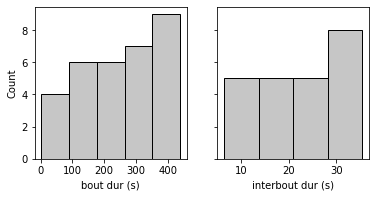

In [20]:
hist_c = [0.7]*3
plot_cdf=True

bout_durs = [(b[-1]-b[0]+1)/fps for b in bouts]
ibi_durs = np.array([(bouts[i+1][0] - b[-1])/fps for i, b in enumerate(bouts[0:-1])])

fig, axn = pl.subplots(1, 2, sharey=True)
sns.histplot(bout_durs, ax=axn[0], color=hist_c, cumulative=plot_cdf)
axn[0].set_xlabel('bout dur (s)')
sns.histplot(ibi_durs, ax=axn[1], color=hist_c, cumulative=plot_cdf)
axn[1].set_xlabel('interbout dur (s)')
for ax in axn:
    ax.set_box_aspect(1)


# Wing extensions

In [21]:

# def plot_wing_extensions(trk, start_frame=0, end_frame=None, ax=None, figsize=(20,3),
#                          c1='lightblue', c2='steelblue', l1='var1', l2='var2', xaxis='sec'):
#     if ax is None:
#         fig, ax = pl.subplots(figsize=figsize)
#     if end_frame is None:
#         end_frame = int(trk.index.tolist()[-1])
#     bout_dur_sec = (end_frame-start_frame)/fps
#     df_ = trk.loc[start_frame:end_frame]
#     ax.plot(df_[xaxis], np.rad2deg(df_['wing_r_ang']), color=c1, label=l1)
#     ax.plot(df_[xaxis], np.rad2deg(df_['wing_l_ang']), color=c2, label=l2)

#     return ax

In [22]:

# def check_nan(wingR):
#     if any(np.isnan(wingR)):
#         wingR_ = pd.Series(wingR)
#         wingR = wingR_.interpolate()
#     return wingR

In [23]:
import plotting as plotutils
cdict = {'wing_r': 'mediumpurple',
        'wing_l': 'orchid'}

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Current bout: 7.29min
Current bout: 6.90min
Current bout: 2.22min
Current bout: 0.85min
Current bout: 4.54min
Current bout: 0.04min
Current bout: 0.36min
Current bout: 2.45min
Current bout: 0.70min


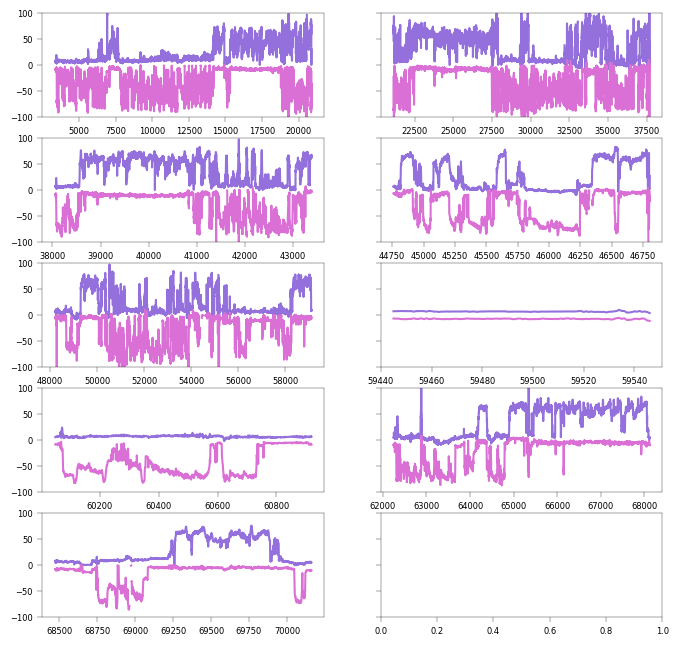

In [24]:

plotutils.set_plot_params(light=False) #lw_axes=1, axis_labelsize=12, tick_labelsize=10, color=[0.7]*3, dpi=300)

fig, axn = pl.subplots(5, 2, figsize=(8,8), sharey=True)

curr_bout= bouts[0]

for ai, curr_bout in enumerate(bouts):
    bout_dur_sec = (curr_bout[-1]-curr_bout[0])/fps
    print("Current bout: %.2fmin" % (bout_dur_sec/60.) )
    start_frame, end_frame = curr_bout[0], curr_bout[-1]
    df_ = trk.loc[start_frame:end_frame]

    # plot
    ax = axn.flatten()[ai]

    ax.plot(np.rad2deg(df_['wing_r_ang']), color=cdict['wing_r'], label='wing_r')
    ax.plot(np.rad2deg(df_['wing_l_ang']), color=cdict['wing_l'], label='wing_l')
    ax.set_ylim([-100, 100])
    #ax.legend(bbox_to_anchor=(1,1), loc='upper right')


In [25]:
importlib.reload(plotutils)
plotutils.set_plot_params(light=True, default_sizes=False, lw_axes=1, 
                          axis_labelsize=10, tick_labelsize=8) #lw_axes=1, axis_labelsize=12, tick_labelsize=10, color=[0.7]*3, dpi=300)


In [26]:
feat['angle_between_deg'] = np.rad2deg(feat['angle_between'])


In [27]:
importlib.reload(plotutils)

<module 'plotting' from '/home/julianarhee/Repositories/flytracker/plotting.py'>

In [28]:
param_list=['wing_l_ang', 'wing_r_ang']
for param in param_list:
    trk[param]=trk[param].interpolate()


In [29]:
plot_params=['wing_l_ang', 'wing_r_ang', 'vel', 'leg_dist', 'angle_between_deg']
limits={}
for param in plot_params:
    if param in feat.columns:
        limits.update({param: (feat[param].min(), feat[param].max())})
    else:
        limits.update({param: (trk[param].min(), trk[param].max())})
limits

{'wing_l_ang': (-3.0100199106850223, 0.20269944624648442),
 'wing_r_ang': (-0.21335121546018584, 3.1109500895529902),
 'vel': (0.00022918385075747084, 110.283832112939),
 'leg_dist': (0.0, 12.818037874119135),
 'angle_between_deg': (0.02035965459630896, 179.84815080786987)}

In [30]:
np.where(feat['vel']==feat['vel'].max())

(array([55154]),)

In [31]:
limits.update({'leg_dist': (0, 10)})
limits.update({'angle_between_deg': (0, 180)})
limits.update({'vel': (0, 15)})

In [32]:
# pl.figure()
# pl.plot(feat[feat['vel']<100]['vel'])


start/end: 3382 20877


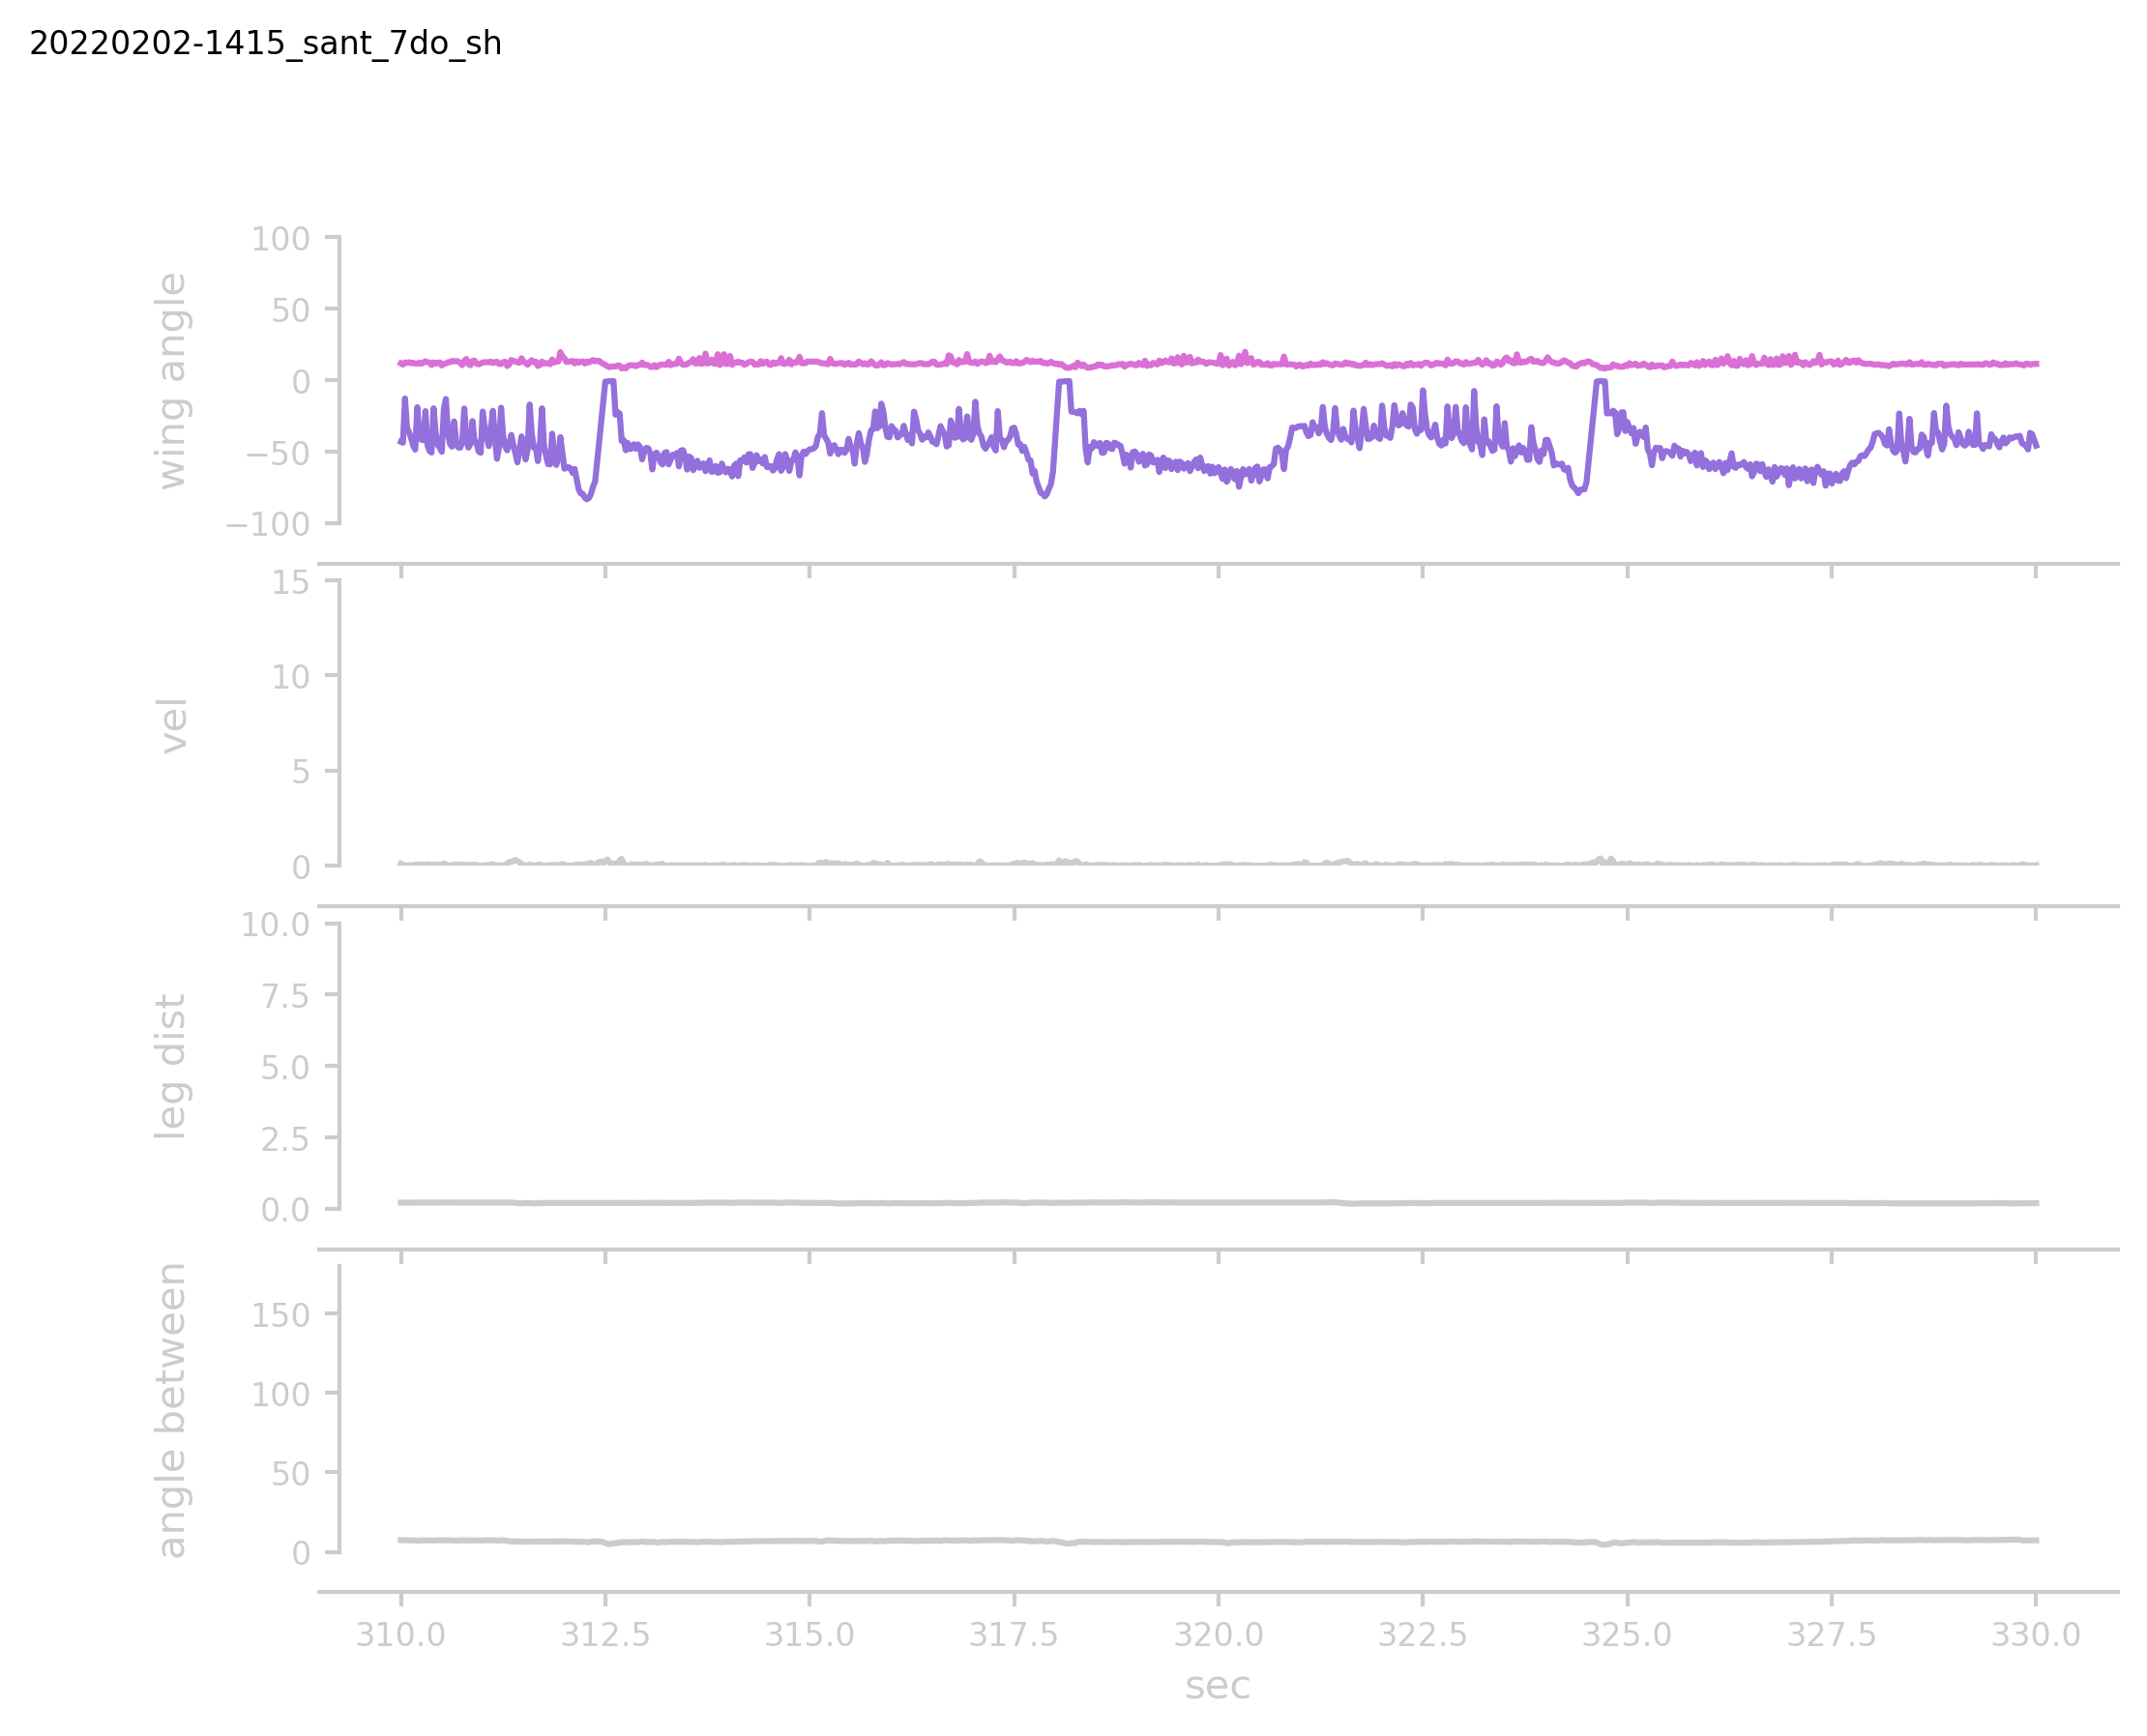

In [54]:
curr_bout= bouts[0]
print("start/end:", curr_bout[0], curr_bout[-1])
start_frame, end_frame = curr_bout[0], curr_bout[-1]
#end_frame=22000
xaxis='sec'

reg_color = [0.8]*3

example = 'rowing'

if example=='rowing':
    start_frame = 12400
    end_frame=13200
elif example=='circling':
    # circling:
    start_frame=18500 #
    end_frame=20500

start_str = int(round(start_frame/fps))
end_str = int(round(end_frame/fps))

fig, axn = pl.subplots(4, 1, figsize=(8,6), sharex=True)
plotutils.label_figure(fig, acquisition)

ax=axn[0]
ax = plot_wing_extensions(trk, start_frame=start_frame, end_frame=end_frame, ax=ax, xaxis=xaxis, #figsize=(20,3),
                         c1=cdict['wing_l'], l1='wing_l', c2=cdict['wing_r'], l2='wing_r')
ax.set_ylim([-100, 100])
ax.set_ylabel('wing angle')
ax.get_yaxis().set_label_coords(-0.07,0.5)

plot_params=['vel', 'leg_dist', 'angle_between_deg']
labels = ['vel', 'leg dist', 'angle between']
for ax, param, lab in zip(axn.flat[1:], plot_params, labels):

    ax.plot(feat.loc[start_frame:end_frame][xaxis], feat.loc[start_frame:end_frame][param], color=reg_color)
    ax.set_ylabel(lab)
    ax.set_ylim(limits[param])
    ax.get_yaxis().set_label_coords(-0.07,0.5)

for ax in axn.flat:
    ax.patch.set_alpha(0)

axn[-1].set_xlabel(xaxis)
    
sns.despine(trim=False, offset={'left': -5, 'bottom': 10})

# figname = '%s-%i-%isec_%s' % (example, start_str, end_str, acquisition)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)


In [34]:
start_frame/fps

462.5

# Create a little gif

In [35]:
import cv2
import matplotlib.gridspec as gridspec


In [36]:
fmt='avi'
movie_path = os.path.join(acq_dir, '%s.%s' % (acquisition, fmt))
assert os.path.exists(movie_path), "Mov does not exist: %s" % movie_path


In [37]:
# Movie cliip
# start_frame = 21136
# end_frame=22000

# start_frame = 14000
# end_frame=15000
print(start_frame, end_frame)
cap = cv2.VideoCapture(movie_path)
# movie=[]
# for fi, fr in enumerate(range(start_frame, end_frame)):
#     if fi % 100 == 0:
#         print("... %i of %i frames" % (int(fi+1), (end_frame-start_frame)))
#     cap.set(1, fr)
#     ret, frame = cap.read()
#     movie.append(frame[:, :, 0])
    
cap.set(1, start_frame)
ret, frame = cap.read()

18500 20500


In [38]:
from matplotlib import animation, rc
from IPython.display import HTML, Image

In [39]:
# equivalent to rcParams['animation.html'] = 'html5'
# rc('animation', html='html5')

#### Test image

In [42]:
# Data points to draw
wingL = np.rad2deg(trk.loc[start_frame:end_frame]['wing_l_ang'].values)
wingR = np.rad2deg(trk.loc[start_frame:end_frame]['wing_r_ang'].values)
wingR = check_nan(wingR)
wingL = check_nan(wingL)

vel = check_nan(feat.loc[start_frame:end_frame]['vel'].values)
leg_dist = check_nan(feat.loc[start_frame:end_frame]['leg_dist'].values)
angle_between = check_nan(feat.loc[start_frame:end_frame]['angle_between_deg'].values)

tsec = trk.loc[start_frame:end_frame]['sec'].values - float(trk.loc[start_frame]['sec'])
tsec[0:5]

array([0.0, 0.024999999999977263, 0.05000000000001137,
       0.07499999999998863, 0.10000000000002274], dtype=object)

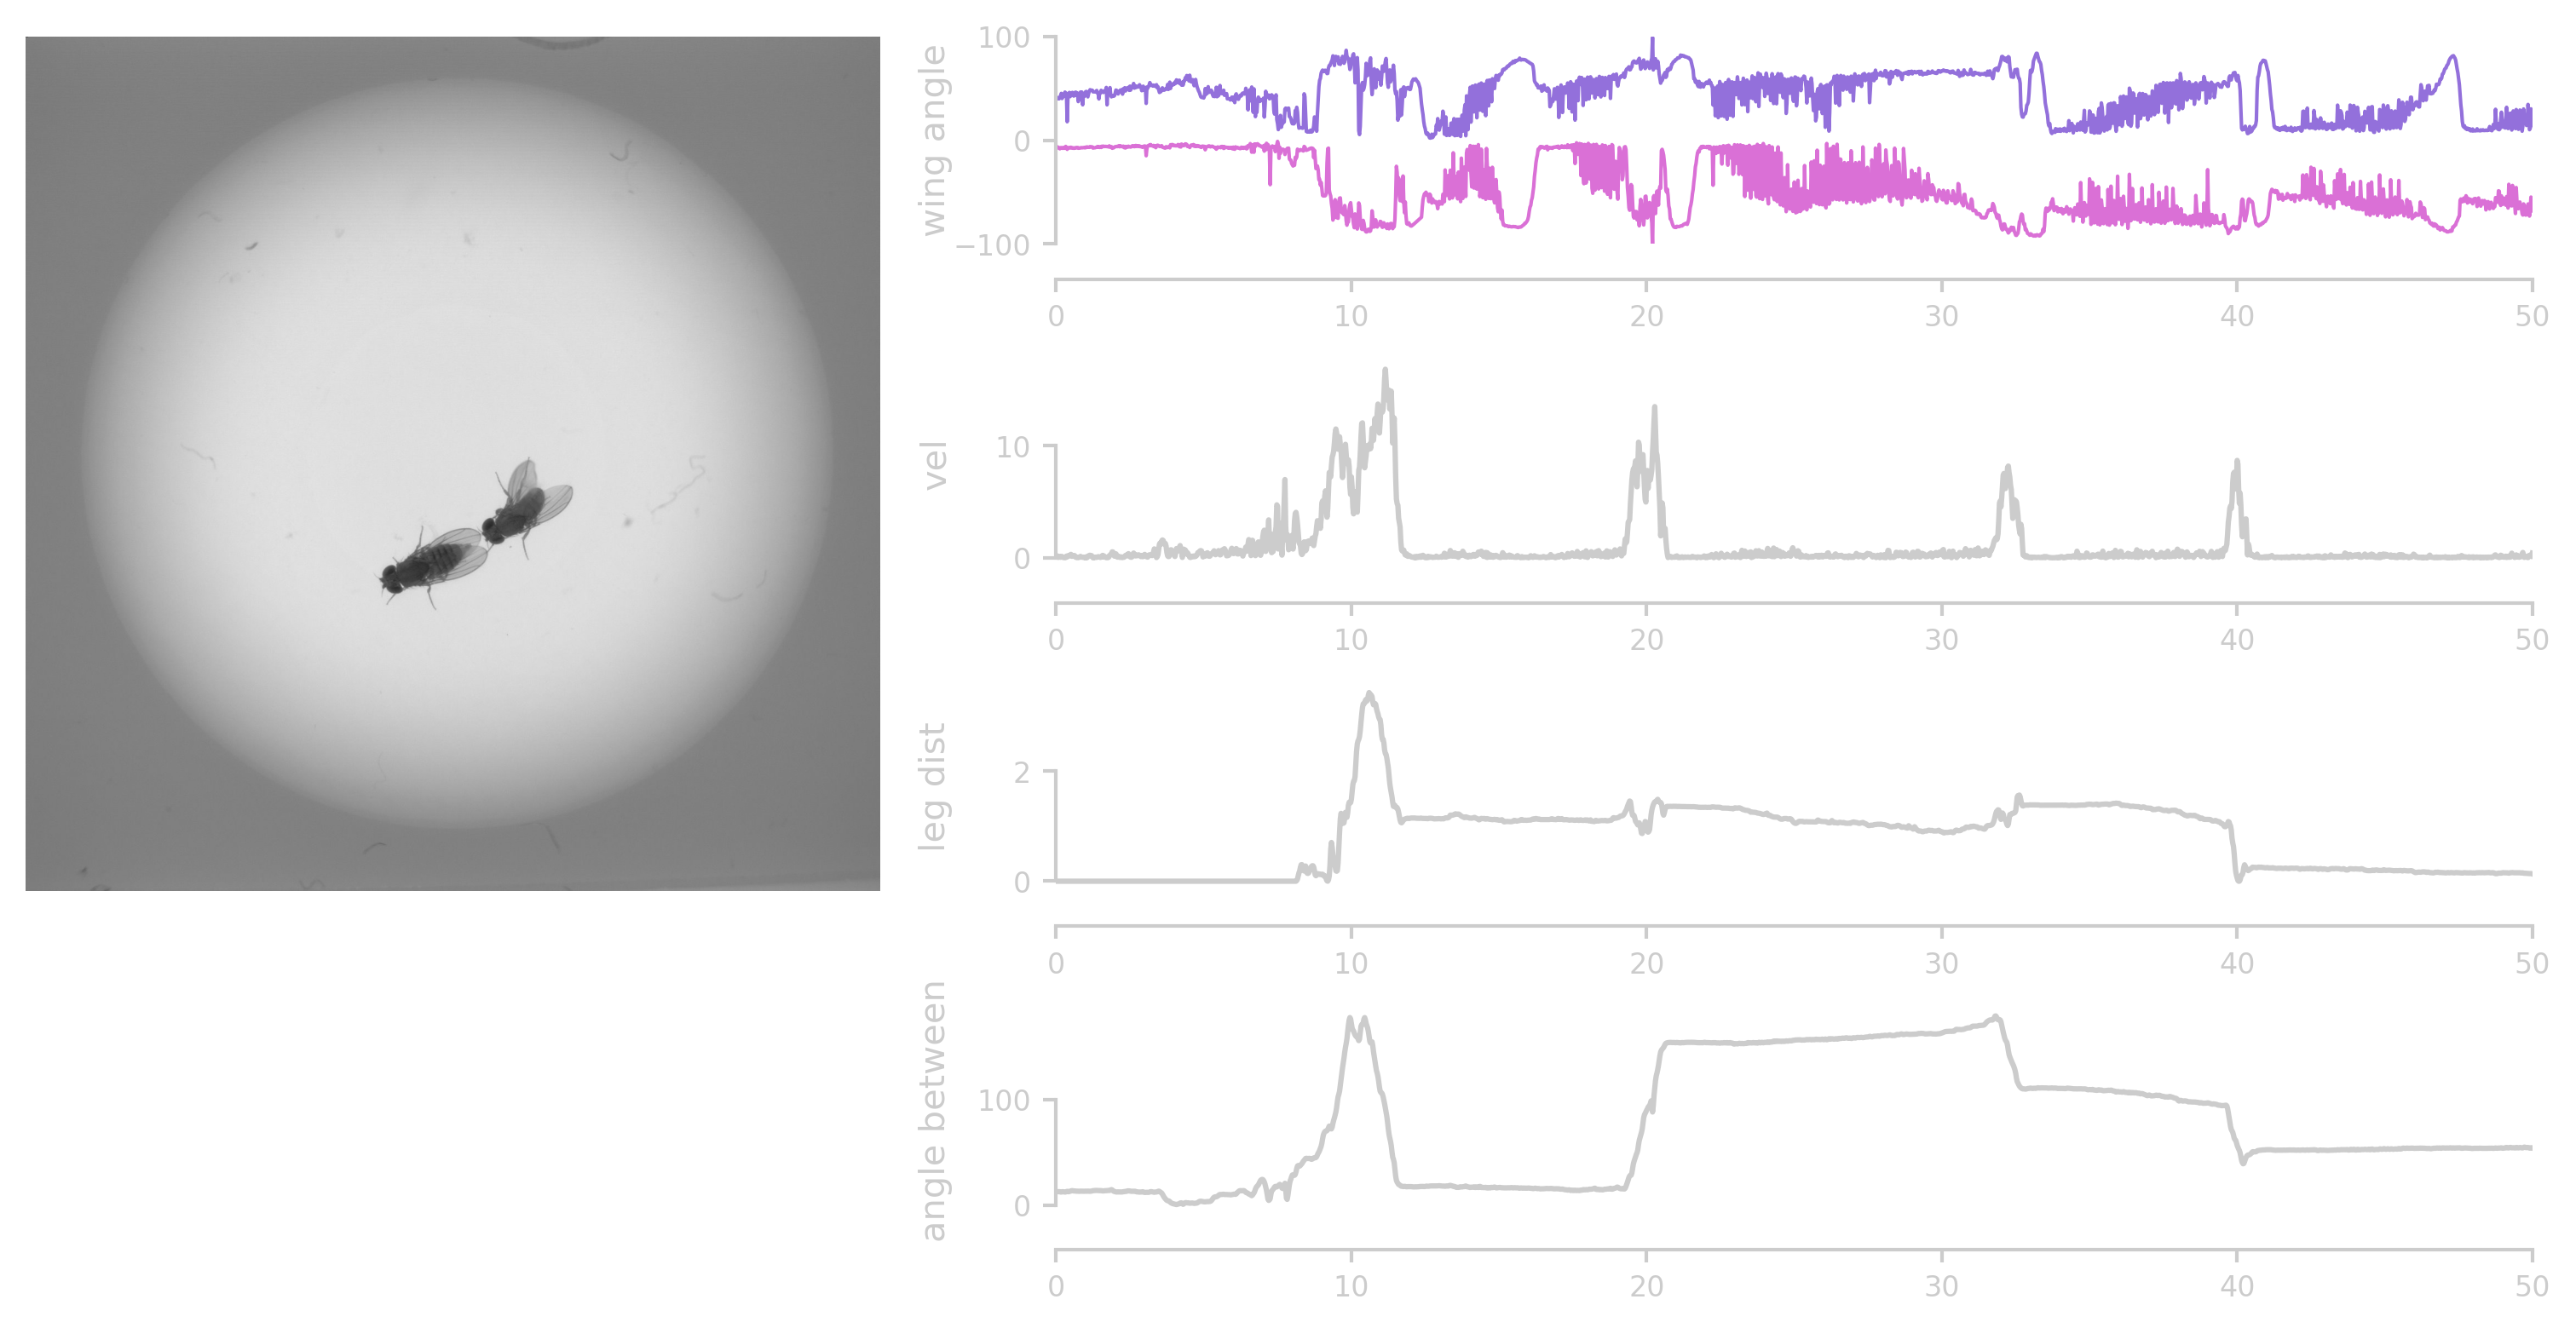

In [43]:
fig = pl.figure(figsize=(10,6), constrained_layout=True)

spec = gridspec.GridSpec(ncols=8, nrows=5, figure=fig)
ax0 = fig.add_subplot(spec[0:3, 0:3]) # video
ax1 = fig.add_subplot(spec[0, 3:])  # wing extensions
ax2 = fig.add_subplot(spec[1, 3:], sharex=ax1)  # vel
ax3 = fig.add_subplot(spec[2, 3:], sharex=ax1)  # dist
ax4 = fig.add_subplot(spec[3, 3:], sharex=ax1)  # angle between

ax0.axis('off')
im = ax0.imshow(frame, aspect='equal', cmap='gray')

ax1.set_ylim([-100, 100])
ax1.set_ylabel('wing angle')
p1, = ax1.plot(tsec, wingL, color=cdict['wing_l'], lw=1)
p2, = ax1.plot(tsec, wingR, color=cdict['wing_r'], lw=1)

ax2.set_ylabel('vel')
p3, = ax2.plot(tsec, vel, color=reg_color)

ax3.set_ylabel('leg dist')
p4, = ax3.plot(tsec, leg_dist, color=reg_color)

ax4.set_ylabel('angle between')
p5, = ax4.plot(tsec, angle_between, color=reg_color)

for ax in fig.axes[1:]:
    ax.set_xlim([0, 50])

for ax in fig.axes:
    ax.patch.set_alpha(0)
    ax.get_yaxis().set_label_coords(-0.07,0.5)

sns.despine(trim=True, offset={'left': 0, 'bottom': 10})


# figname = '%s-%i-%isec_video_%s' % (example, start_str, end_str, acquisition)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)


In [44]:
outf = os.path.join(dst_dir, '%s-bout_%s.gif' % (example, acquisition))
outf

'/home/julianarhee/Documents/projects/flytracker-analysis/examples/circling-bout_20220202-1415_sant_7do_sh.gif'

/home/julianarhee/Documents/projects/flytracker-analysis/examples/circling-bout_20220202-1415_sant_7do_sh.mp4


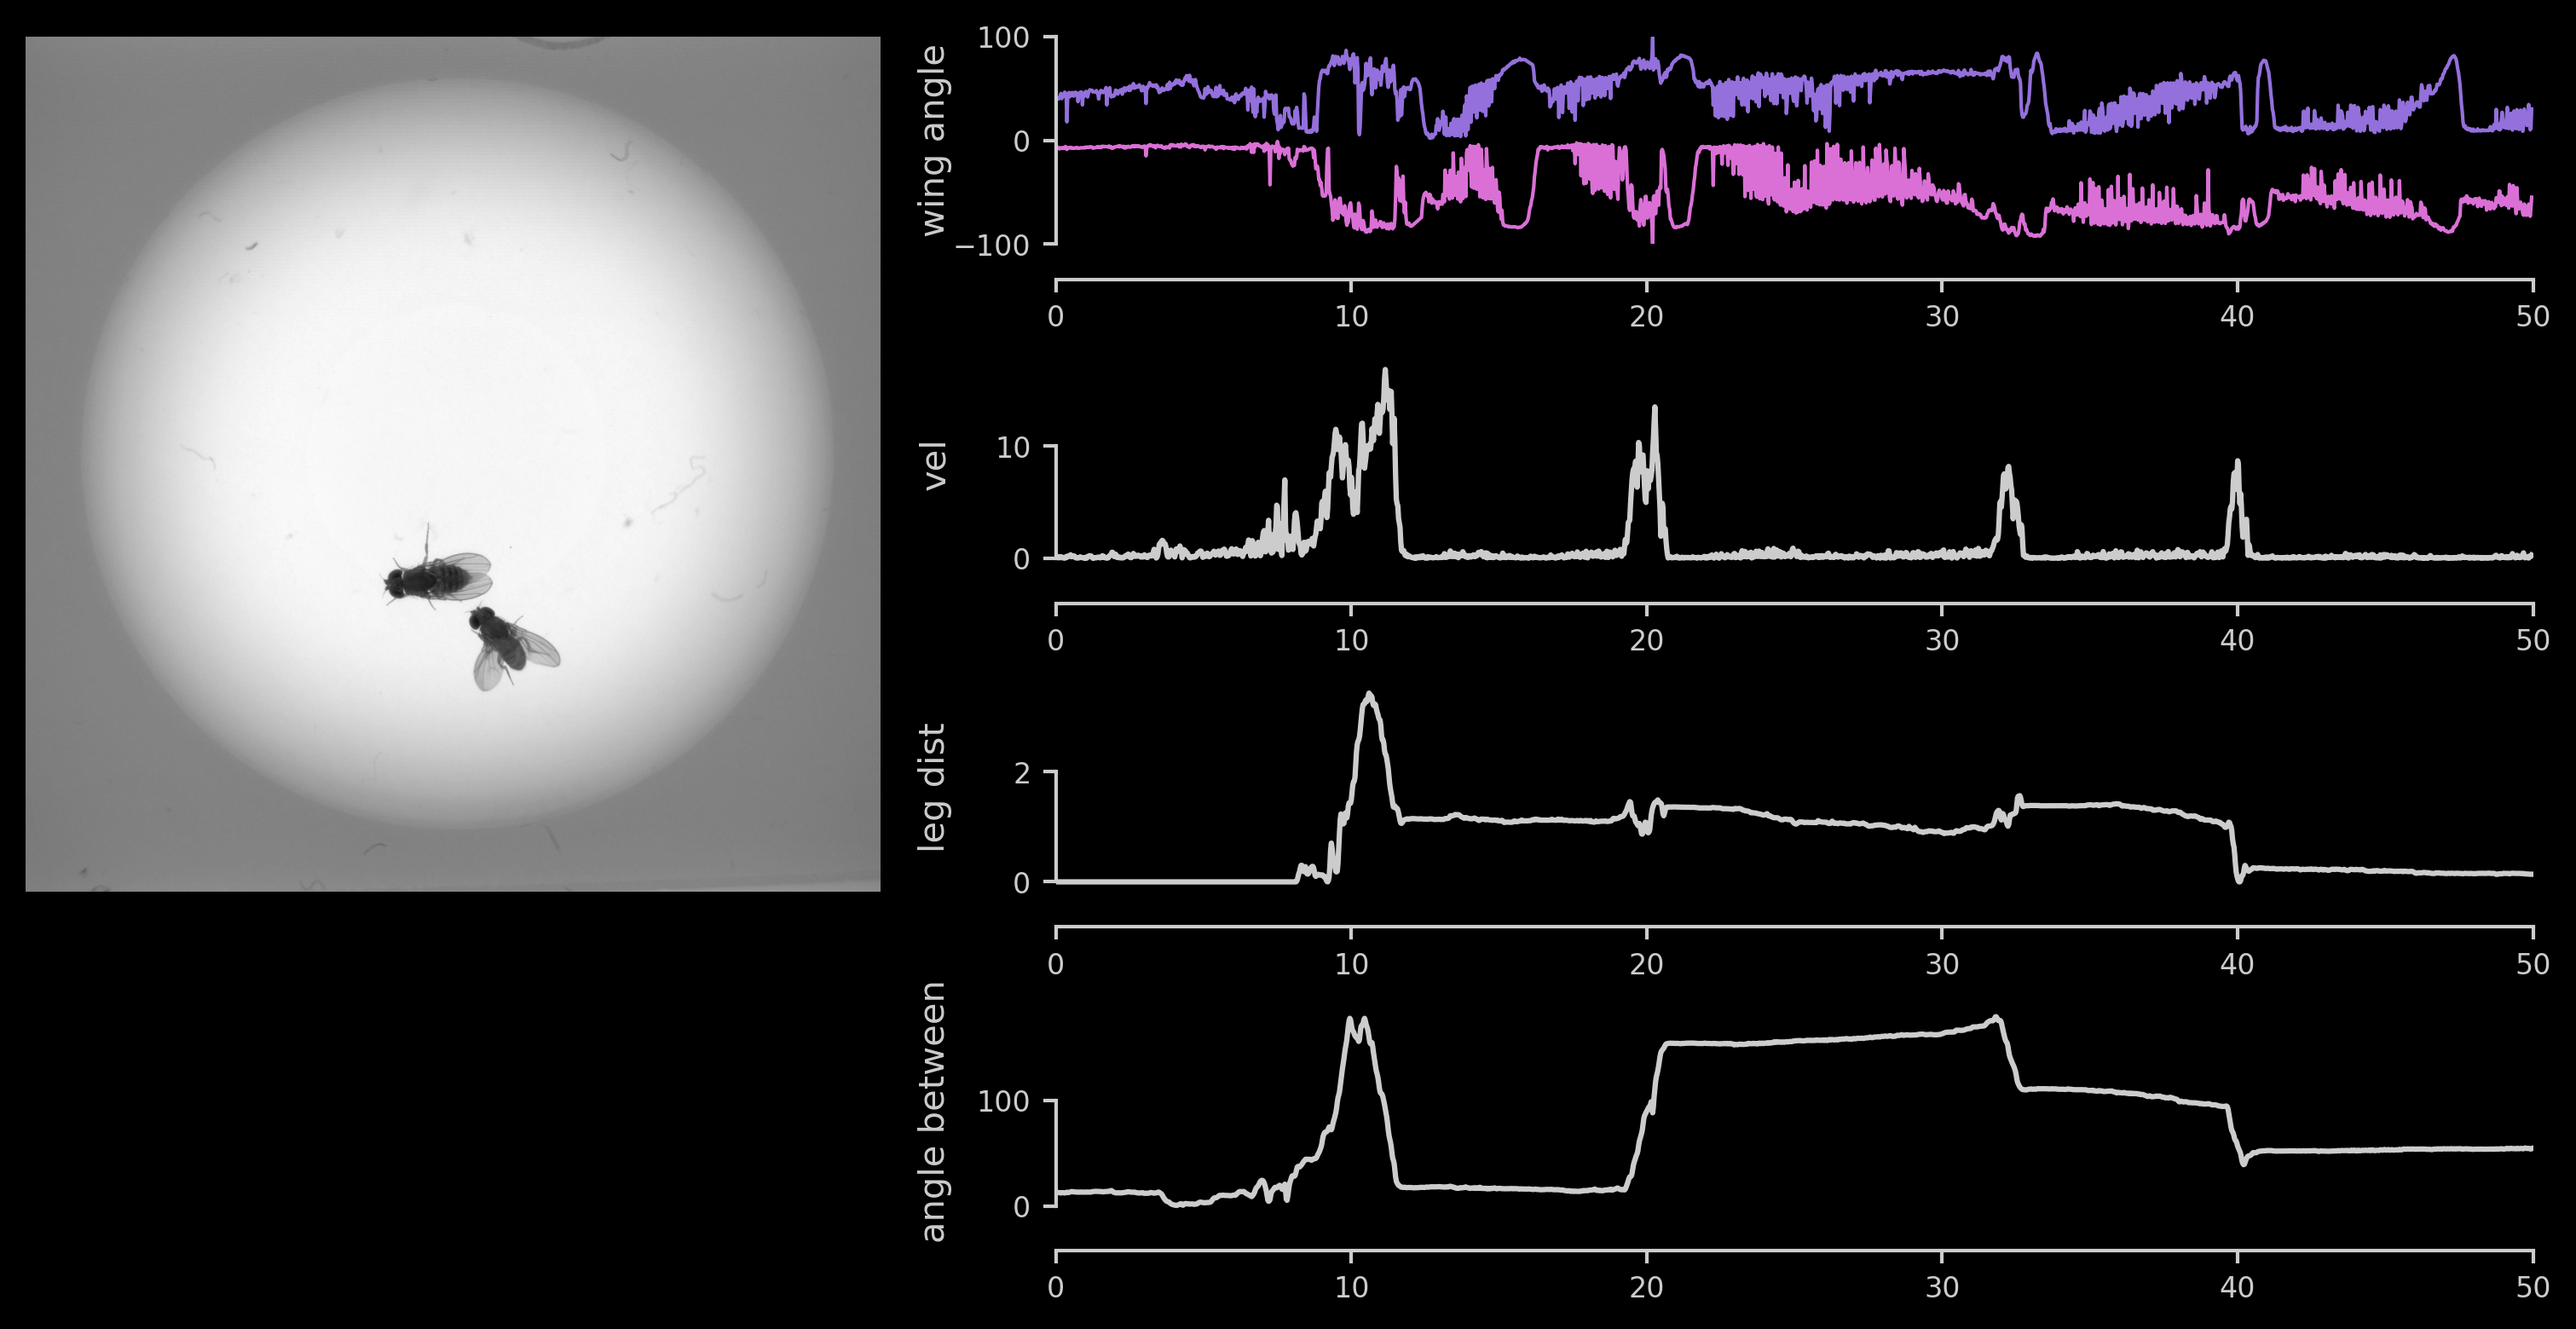

In [46]:
# Set playblack
frame_ixs = list(range(start_frame, end_frame))

nframes =  len(frame_ixs) #start_frame
video_rate=80.
interval = (1./video_rate) * 1E3
nx, ny, _ = frame.shape
# ------------------------------------
fig = pl.figure(figsize=(10,6), constrained_layout=True)
#fig.patch.set_alpha(0)
fig.patch.set_facecolor('k') #fig.patch.set_alpha(0)

spec = gridspec.GridSpec(ncols=8, nrows=5, figure=fig)
ax0 = fig.add_subplot(spec[0:3, 0:3]) # video
ax1 = fig.add_subplot(spec[0, 3:])  # wing extensions
ax2 = fig.add_subplot(spec[1, 3:], sharex=ax1)  # vel
ax3 = fig.add_subplot(spec[2, 3:], sharex=ax1)  # dist
ax4 = fig.add_subplot(spec[3, 3:], sharex=ax1)  # angle between

ax0.axis('off')
im = ax0.imshow(frame, aspect='equal', cmap='gray')

ax1.set_ylim([-100, 100])
ax1.set_ylabel('wing angle')
p1, = ax1.plot(tsec, wingL, color=cdict['wing_l'], lw=1)
p2, = ax1.plot(tsec, wingR, color=cdict['wing_r'], lw=1)

ax2.set_ylabel('vel')
p3, = ax2.plot(tsec, vel, color=reg_color)

ax3.set_ylabel('leg dist')
p4, = ax3.plot(tsec, leg_dist, color=reg_color)

ax4.set_ylabel('angle between')
p5, = ax4.plot(tsec, angle_between, color=reg_color)

for ax in fig.axes[1:]:
    ax.set_xlim([0, 50])

for ax in fig.axes:
    ax.patch.set_alpha(0)
    ax.get_yaxis().set_label_coords(-0.07,0.5)

sns.despine(trim=True, offset={'left': 0, 'bottom': 10})
# -----------------------------------------------------------------


# def animate_with_movie(nframes, movie, x, p1_vals, p2_vals, video_rate, cdict):
# initialization function: plot the background of each frame
def init():
    im.set_data(np.zeros((nx, ny)))
    p1.set_data([], [])
    p2.set_data([], [])
    p3.set_data([], [])
    p4.set_data([], [])
    p5.set_data([], [])
    return (im, p1, p2, p3, p4, p5,)

# animation function. This is called sequentially
def update(i): #, im, movie, tsec, p1, p2, p1_vals, p2_vals):
#def animate(i):
    p1.set_data(tsec[:i], wingL[:i])
    p2.set_data(tsec[:i], wingR[:i])
    p3.set_data(tsec[:i], vel[:i])
    p4.set_data(tsec[:i], leg_dist[:i])
    p5.set_data(tsec[:i], angle_between[:i])
#     p1.set_data(wingL[:i])
#     p2.set_data( wingR[:i])
#     p3.set_data(vel[:i])
#     p4.set_data(leg_dist[:i])
#     p5.set_data(angle_between[:i])
    cap.set(1, frame_ixs[i])
    ret, frame = cap.read()
    im.set_data(frame[:,:,0])
    #im.set_data(movie[i])
    return (im, p1, p2, p3, p4, p5)

# call the animator. blit=True means only re-draw the parts that have changed.
#fargs = [im, movie, tsec, p1, p2, wingL, wingR]
anim = animation.FuncAnimation(fig, update, nframes, init_func=init, ##fargs=fargs, init_func=init, 
                        interval=interval, blit=True)

# anim = animate_with_movie(nframes, movie, tsec, wingL, wingR, video_rate, cdict)
outf = os.path.join(dst_dir, '%s-bout_%s.mp4' % (example, acquisition))
writervideo = animation.FFMpegWriter(fps=video_rate) 
#writervideo = animation.PillowWriter(fps=video_rate) 
anim.save(outf, writer=writervideo)

print(outf)
anim

In [ ]:
outf

In [2]:
acquisition

NameError: name 'acquisition' is not defined

# Transform coords

In [22]:

posM = trackdf[trackdf['id']==male_id][['pos_x', 'pos_y']]
posF = trackdf[trackdf['id']==female_id][['pos_x', 'pos_y']]

angle_between = np.rad2deg(featdf[featdf['id']==male_id]['angle_between']) # 0=facing the same dir (head-to-rear), pi=facing opposite dirs (rear-to-rear)
headingM = featdf[featdf['id']==male_id]['facing_angle']
headingF = featdf[featdf['id']==female_id]['facing_angle']



0    154.958924
1    154.672958
2    154.094972
3    153.840900
4    154.389388
Name: angle_between, dtype: float64

In [31]:
dists = pd.DataFrame(data=util.euclidean_dist(posM, posF, cols=['pos_x', 'pos_y']), columns=['distance'], index=posM.index)
dists.head()

,distance
0,292.475353
1,292.952202
2,295.149308
3,295.860121
4,295.132227


In [27]:
dists['interaction'] = False
dists.loc[dists['distance']<max_dist_to_other, 'interaction'] = True

array([292.47535303, 292.95220196, 295.1493082 , ..., 266.67161283,
       269.62774396, 273.64364835])

In [ ]:
feat = featdf[featdf['id']==fly_id].copy()
feat = util.threshold_courtship_bouts(feat, max_dist_to_other=max_dist_to_other, max_facing_angle=max_facing_angle)
feat.head()
trk = trackdf[trackdf['id']==fly_id].copy()
trk.loc[feat['facing_angle'].isna()] = np.nan

fps = calib['FPS']
trk['frame'] = trk.index.tolist()
trk['sec'] = trk['frame']/fps